# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn import datasets

# Neural Network Implementation

In [87]:
class Neural_Network():
    def __init__(self, neurons, Activations, epochs=1000, learning_rate=0.001, loss='squared', test_sample=None, test_epoch=5): 
        # arguments: an array "neurons" consist of number of neurons for each layer, 
        # an array "activations" consisting of activation functions used for the hidden layers and output layer
        self.inputSize = neurons[0] # Number of neurons in input layer
        self.outputSize = neurons[-1] # Number of neurons in output layer
        self.layers = len(neurons)
        self.weights = [] #weights for each layer
        self.biases = [] #biases in each layer 
        self.layer_activations = [] #activations in each layer
        self.epochs = epochs #number of epochs to train the network
        self.learning_rate = learning_rate #learning rate used for training
        self.loss_function = loss
        self.test_sample = test_sample
        self.test_epoch = test_epoch
        self.test_errors = []
        np.random.seed(0)
        for i in range(len(neurons)-1): 
            self.weights.append(np.random.rand(neurons[i+1],neurons[i])) #weight matrix between layer i and layer i+1
            self.biases.append(np.random.rand(neurons[i+1],1))
            self.layer_activations.append(Activations[i]) #activations for each layer
        
    def sigmoid(self, z): # sigmoid activation function
        #Fill in the details to compute and return the sigmoid activation function                  
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoidPrime(self, z): # derivative of sigmoid activation function
        #Fill in the details to compute and return the derivative of sigmoid activation function
        return self.sigmoid(z) * (1 - self.sigmoid(z))
                          
    def tanh(self, z): # hyperbolic tan activation function
        #Fill in the details to compute and return the tanh activation function                  
        exp_z = np.exp(z)
        exp_z_negative = np.exp(-z)
        return (exp_z - exp_z_negative) / (exp_z + exp_z_negative)  
    
    def tanhPrime(self, z): # derivative of hyperbolic tan activation function
        #Fill in the details to compute and return the derivative of tanh activation function
        return 1 - self.tanh(z) ** 2
                          
    def linear(self, z): # Linear activation function
        #Fill in the details to compute and return the linear activation function                                    
        return z
    
    def linearPrime(self, z): # derivative of linear activation function
        #Fill in the details to compute and return the derivative of activation function                                                      
        return np.ones(z.shape)

    def ReLU(self, z): # ReLU activation function
        #Fill in the details to compute and return the ReLU activation function                  
        return np.where(z < 0, 0, z)
    
    def ReLUPrime(self, z): # derivative of ReLU activation function
        #Fill in the details to compute and return the derivative of ReLU activation function
        return np.where(z < 0, 0, 1)
    
    def softmax(self, z): # Softmax activation function
        z = z - np.max(z, axis=0)
        z_exp = np.exp(z)
        return z_exp / np.sum(z_exp, axis=0)          
    
    def forward(self, a): # function of forward pass which will receive input and give the output of final layer
        # Write the forward pass using the weights and biases to find the predicted value and return them.
        layer_activations_a = [a] #store the input as the input layer activations
        layer_dot_prod_z = []
        for i, param in enumerate(zip(self.biases, self.weights)):
            b, w = param[0], param[1]
            z = np.dot(w, a) + b
            if self.layer_activations[i].lower()  == 'sigmoid':
                a = self.sigmoid(z)
            elif self.layer_activations[i].lower() == 'relu':
                a = self.ReLU(z)    
            elif self.layer_activations[i].lower() == 'tanh':   
                a = self.tanh(z)
            elif self.layer_activations[i].lower() == 'linear':
                a = self.linear(z)
            elif self.layer_activations[i].lower() == 'softmax':
                a = self.softmax(z)
            layer_dot_prod_z.append(z)
            layer_activations_a.append(a)

        return a, layer_dot_prod_z, layer_activations_a
        
    def loss(self, Y_hat, Y):
        #Implement the loss function
        epsilon = 10 ** -5
#         print(f'Y : {Y.shape}')
#         print(f'Y_hat : {Y_hat.shape}')
        if self.loss_function.lower() == 'cross-entropy':
            Y_hat = np.where(Y_hat == 1, 1 - epsilon, Y_hat)
            Y_hat = np.where(Y_hat == 0, epsilon, Y_hat)
            error = - Y * np.log(Y_hat) - (1 - Y) * np.log(1 - Y_hat) 
        elif self.loss_function.lower() == 'squared':
            error = 0.5 * (Y_hat - Y) ** 2
        return error

    def loss_grad(self, Y_hat, Y):
        #Return the gradient of the loss function -
        # 1. w.r.t. activations for squared-error 
        # 2. w.r.t. z for cross-entropy loss
        grad = Y_hat - Y
        return grad
        
    def backward(self, x, y, zs, activations): # find the loss and return derivative of loss w.r.t every parameter
        # Write the backpropagation algorithm here to find the gradients of weights and biases and return them.
        # Assuming L2 loss
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        delta = self.loss_grad(activations[-1], y)
        if self.layer_activations[-1].lower() == 'sigmoid':
            delta = delta * self.sigmoidPrime(zs[-1])
        elif self.layer_activations[-1].lower() == 'relu':
            delta = delta * self.ReLUPrime(zs[-1])
        elif self.layer_activations[-1].lower() == 'tanh':
            delta = delta * self.tanhPrime(zs[-1])   
        elif self.layer_activations[-1].lower() == 'linear':
            delta = delta * self.linearPrime(zs[-1])
        
        # Number of training examples = m
        m = delta.shape[1]
        # fill in the appropriate details for gradients of w and b
        grad_w[-1] = np.dot(delta, activations[-2].T) / m 
        grad_b[-1] = np.sum(delta, axis=1, keepdims=True) / m

        for l in range(2, self.layers): # Here l is in backward sense i.e. last lth layer
            z = zs[-l]
            if self.layer_activations[-l].lower() == 'sigmoid':
                prime = self.sigmoidPrime(z)
            elif self.layer_activations[-l].lower() == 'relu':
                prime = self.ReLUPrime(z)
            elif self.layer_activations[-l].lower() == 'tanh':   
                prime = self.tanhPrime(z)
            elif self.layer_activations[-l].lower() == 'linear':
                prime = self.linearPrime(z)

            #Compute delta, gradients of b and w
            delta = np.dot(self.weights[-l+1].T, delta) * prime
            grad_w[-l] = np.dot(delta, activations[-l-1].T) / m 
            grad_b[-l] = np.sum(delta, axis=1, keepdims=True) / m

        return (grad_b, grad_w)   

    def update_parameters(self, grads, learning_rate): # update the parameters using the gradients
        # update weights and biases using the gradients and the learning rate
        grad_b, grad_w = grads[0], grads[1]       
        
        #Implement the update rule for weights  and biases
        self.weights = [self.weights[i] - learning_rate * grad_w[i] for i in range(len(self.weights))]
        self.biases = [self.biases[i] - learning_rate * grad_b[i] for i in range(len(self.biases))] 
        
    def train(self, X, Y, minibatch=False, batch_size=20, verbose=False): # receive the full training data set
        lr = self.learning_rate # learning rate
        epochs = self.epochs # number of epochs
        loss_list = []
        for e in range(epochs): 
            if self.test_sample is not None and e % self.test_epoch == 0:
                test_X, test_Y = self.test_sample
                losses = []
                for q in range(len(test_X)):
                    if minibatch == False:
                        rows_x, cols_x = test_X[q].shape[0], 1
                        rows_y, cols_y = test_Y[q].shape[0], 1
                    else:
                        rows_x, cols_x = test_X[q].shape[1], X[q].shape[0]
                        rows_y, cols_y = test_Y[q].shape[1], Y[q].shape[0]

                    test_x = np.resize(test_X[q], (rows_x, cols_x))
                    test_y = np.resize(test_Y[q],(rows_y, cols_y))

                    out, dot_prod_z, activations_a = self.forward(test_x)
                    loss = self.loss(out, test_y)
                    losses.append(loss)
                loss_mean = np.mean(np.array(losses))
                self.test_errors.append(loss_mean)
            
            losses = []
            for q in range(len(X)):
                if minibatch == False:
                    rows_x, cols_x = X[q].shape[0], 1
                    rows_y, cols_y = Y[q].shape[0], 1
                else:
                    rows_x, cols_x = X[q].shape[1], X[q].shape[0]
                    rows_y, cols_y = Y[q].shape[1], Y[q].shape[0]

                train_x = np.resize(X[q], (rows_x, cols_x))
                train_y = np.resize(Y[q],(rows_y, cols_y))
                
                out, dot_prod_z, activations_a = self.forward(train_x)
                loss = self.loss(out, train_y)
                grads = self.backward(train_x, train_y, dot_prod_z, activations_a) # find the gradients using backward pass
                self.update_parameters(grads, lr)
                losses.append(loss)
            
            loss_mean = np.mean(np.array(losses))
            loss_list.append(loss_mean)
            if verbose:
                print(f'Epoch: {e} Loss: {loss_mean}')
        return loss_list
        
    def predict(self, x):
        print ("Input : \n" + str(x))
        prediction,_,_ = self.forward(x)
        print ("Output: \n" + str(prediction))


# Miscellaneous Functions

### One-hot encoder

In [3]:
# a method for creating one hot encoded labels 
def onehotencoding(Y):
    rows = Y.shape[0]
    values = {e:i for i, e in enumerate(np.unique(Y))}
    y_enc = np.zeros((rows, len(values)))
    for i in range(rows):
        j = values[Y[i]]
        y_enc[i][j] = 1
    return y_enc

### Create mini-batches

In [4]:
#a method to create minibatches 
def create_minibatches(X, Y, minibatchsize):
    numbatches = int(np.ceil(len(X)/minibatchsize))
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X_minibatches = []
    Y_minibatches = [] 
    for i in range(numbatches):
        idx_minibatch = idx[i*minibatchsize:min(len(idx),(i+1)*minibatchsize)]
        xn = np.take(X,idx_minibatch,axis=0) 
        yn = np.take(Y,idx_minibatch,axis=0)
        X_minibatches.append(xn)
        Y_minibatches.append(yn)
    X_minibatches, Y_minibatches = np.array(X_minibatches), np.array(Y_minibatches)
    return X_minibatches, Y_minibatches

### Test mini-batches created

In [5]:
def test_create_minibatches():
    X = []
    Y = []
    batch_size = 2
    for i in range(20):
        if(i % 2 == 0):
            X.append([np.random.randint(1,10) for i1 in range(inputsize)])
            Y.append(1)
        else:
            X.append([np.random.randint(-10,1) for i1 in range(inputsize)])
            Y.append(0)
    X = np.array(X)
    Y = np.array(Y)

    X_mb, Y_mb = create_minibatches(X,Y,batch_size)
    print(X_mb, Y_mb)


### Generate random data

In [6]:
def generateData(inputsize=3, onehotencoded=False, minibatch=False, batch_size=5):
    X = []
    Y = []
    random.seed(0)
    for i in range(500):
        if(i % 2 == 0):
            X.append([random.randint(1,10) for i1 in range(inputsize)])
            Y.append(1)
        else:
            X.append([random.randint(-10,1) for i1 in range(inputsize)])
            Y.append(0)
    X = np.array(X)
    Y = np.array(Y)
    if onehotencoded:
        Y = onehotencoding(Y)

    if minibatch == False:
        train_X = X
        train_Y = Y
    else:
        train_X, train_Y = create_minibatches(X, Y, batch_size)
    return train_X, train_Y

# Question 2

## Question 2(1)(d)

(500, 3) (500, 1)


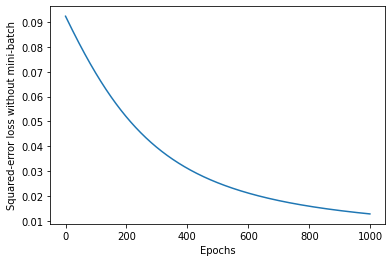

In [111]:
def plot_2d():
    #D_in is input dimension
    #H1 is dimension of first hidden layer 
    #H2 is dimension of second hidden layer
    #D_out is output dimension.
    epochs = 1000
    learning_rate = 10 ** -4
    inputsize = 3
    loss_function = 'squared'
    
    onehotencoded = False
    minibatch = False
    train_X, train_Y = generateData(inputsize, onehotencoded, minibatch)
    train_Y = train_Y.reshape((train_Y.shape[0], 1))
    
    print(train_X.shape, train_Y.shape)

    D_in, H1, H2, H3, H4, D_out = inputsize, 10, 10, 100, 100, 1 
    # list of number of neurons in the layers sequentially.
    neurons = [D_in, H1, H2, H3, H4, D_out] 
    # activations in each layer (Note: the input layer does not have any activation)
    activation_functions = ['linear','linear', 'tanh', 'relu', 'sigmoid'] 

    # Train the network
    neuralnet = Neural_Network(neurons, activation_functions, epochs, learning_rate, loss_function)
    loss = neuralnet.train(train_X, train_Y, minibatch=minibatch)
    
    # Plot the results
    plt.plot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Squared-error loss without mini-batch')
    plt.show()

    return neuralnet, loss

neuralnet, loss_2d = plot_2d()

## Question 2(1)(e)

(25, 20, 3) (25, 20, 1)


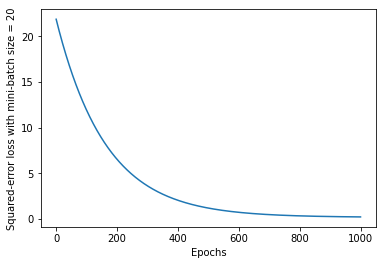

In [112]:
def plot_2e():
    #D_in is input dimension
    #H1 is dimension of first hidden layer 
    #H2 is dimension of second hidden layer
    #D_out is output dimension.
    epochs = 1000
    learning_rate = 10 ** -5
    inputsize = 3
    loss_function = 'squared'

    onehotencoded = False
    minibatch = True
    batch_size = 20
    train_X, train_Y = generateData(inputsize, onehotencoded, minibatch, batch_size)
    num_batches = train_X.shape[0]
    train_Y = train_Y.reshape(num_batches, batch_size, 1)
    
    print(train_X.shape, train_Y.shape)

    D_in, H1, H2, H3, H4, D_out = inputsize, 10, 10, 5, 20, 1 
    # list of number of neurons in the layers sequentially.
    neurons = [D_in, H1, H2, H3, H4, D_out] 
    # activations in each layer (Note: the input layer does not have any activation)
    activation_functions = ['linear','linear', 'tanh', 'tanh', 'relu'] 

    # Train the network
    neuralnet = Neural_Network(neurons, activation_functions, epochs, learning_rate, loss_function)
    loss = neuralnet.train(train_X, train_Y, minibatch=minibatch)

    # Plot the results
    plt.plot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Squared-error loss with mini-batch size = 20')
    plt.show()

    return neuralnet, loss

neuralnet, loss_2e = plot_2e()

## Question 2(1)(f)
### Observation 
Mini-batch gradient descent performs better than squared-error gradient descent.
The reason for this is that fewer number of updates lead to a stable and better convergence that can be verified with the graph below.
Since the number of updates is less, it is also computationally less extensive.

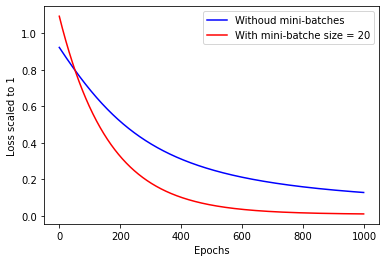

In [114]:
def plot_2f(loss_2d, loss_2e):
    loss_2d = np.array(loss_2d) * 10
    loss_2e = np.array(loss_2e) / 20
    
    line, = plt.plot(loss_2d, 'b')
    line.set_label('Withoud mini-batches')
    line, = plt.plot(loss_2e, 'r')
    line.set_label('With mini-batche size = 20')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss scaled to 1')
    plt.show()

plot_2f(loss_2d.copy(), loss_2e.copy())

## Question 2(2)

### Exploding and vanishing gradients

# Question 3

### Import dataset

In [115]:
def loadData_3():
    data = datasets.load_digits()
    return data['data'], data['target']

### Data preprocessing

In [116]:
def preprocess_3():
    X, Y = loadData_3()
    X = X / 255
    return X, Y
    

### Neural network architecture

In [117]:
# Neural network with Squared-Error loss
def train_3_se(batch_size=1, learning_rate=0.0001): 
    # Number of neurons in each layer
    neurons = [64, 256, 128, 1]
    activations = ['sigmoid', 'sigmoid', 'relu']
    loss_function = 'squared'
    epochs = 200

    # Data preprocessing
    onehotencoded = False
    minibatch = True
    X, Y = preprocess_3()
    # Need to choose train set size based on the batch_sizes in question 3(e)
    X, Y = X[:1500], Y[:1500]
    X, Y = create_minibatches(X, Y, batch_size)
    
    # Split training and test data
    num_training = 1500
    num_batches = num_training // batch_size
    train_X, train_Y = X[: num_batches], Y[: num_batches]    
    train_Y = train_Y.reshape((num_batches, batch_size, 1))

    print(train_X.shape, train_Y.shape)
    
    # Train the network
    neuralnet = Neural_Network(neurons, activations, epochs, learning_rate, loss_function)
    loss = neuralnet.train(train_X, train_Y, minibatch=minibatch)    
    return neuralnet, loss
    
neuralnet_3_se, loss_3_se = train_3_se(1, 10**-7)

(1500, 1, 64) (1500, 1, 1)


In [118]:
# Neural network with Cross-Entropy loss
def train_3_ce(batch_size=1, learning_rate=0.0001):
    # Number of neurons in each layer
    neurons = [64, 256, 128, 10]
    activations = ['sigmoid', 'sigmoid', 'softmax']
    loss_function = 'cross-entropy'
    epochs = 200

    # Data preprocessing
    onehotencoded = False
    minibatch = True
    X, Y = preprocess_3()
    # Need to choose train set size based on the batch_sizes in question 3(e)
    X, Y = X[:1500], Y[:1500]
    Y = onehotencoding(Y)
    X, Y = create_minibatches(X, Y, batch_size)

    # Split training and test data
    num_training = 1500
    num_batches = num_training // batch_size
    train_X, train_Y = X[: num_batches], Y[: num_batches]
    train_Y = train_Y.reshape((num_batches, batch_size, 10))    

    print(train_X.shape, train_Y.shape)
    
    # Train the network
    neuralnet = Neural_Network(neurons, activations, epochs, learning_rate, loss_function)
    loss = neuralnet.train(train_X, train_Y, minibatch=minibatch)
    return neuralnet, loss

neuralnet_3_ce, loss_3_ce = train_3_ce(1, 10**-6)

(1500, 1, 64) (1500, 1, 10)


## Question 3(a)

### Squared Error Loss

Squared-error loss function is used in the regression scenario with number of output layer neurons = 1.
This neuron predicts values in the range 0 to 9. The activation function used here is ReLU.

### Cross-Entropy Loss
Cross-entropy loss function is used for multi-class classification and the number of output layer neurons in this case = 10.
The output layer returns one-hot encoded values for labels in the range 0 to 9.
Activation function used in this case is softmax.

## Question 3(b)
### Plot squared-error and cross-entropy loss

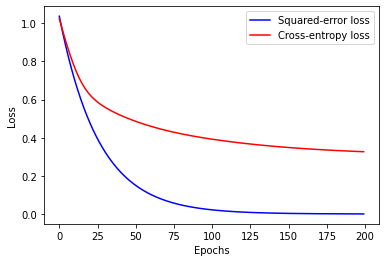

In [125]:
def plot_3b(loss_se, loss_ce):
    # Scale the losses appropriately
    loss_se = np.array(loss_se) / 1600
    loss_ce = np.array(loss_ce) / 1.1
    plt.ylabel(f'Loss')
    plt.xlabel('Epochs')
    
    line, = plt.plot(loss_se, 'b')
    line.set_label(f'Squared-error loss')
    # Uncomment the below lines to display true plots separately
    # plt.legend()
    # plt.show()

    line, = plt.plot(loss_ce, 'r')
    line.set_label(f'Cross-entropy loss')

    plt.legend()
    plt.show()

plot_3b(loss_3_se.copy(), loss_3_ce.copy())

### Observations
The squared-error loss initially is much larger than the cross-entropy loss owing to the fact that it used ReLu activation function. However, SE decays pretty quickly since the number of updates are significantly larger than CE.

The learning rate used are:
1. Squared-error = 10 ^ (-7)
2. Cross-entropy = 10 ^ (-6)


## Question 3(c)
### Comparision of squared-error loss by varying learning rates
The given learning rates are way too large for the model. 
Therefore, modified learning rates which are scaled by a factor of 10^(-4) are used.

(1500, 1, 64) (1500, 1, 1)
(1500, 1, 64) (1500, 1, 1)
(1500, 1, 64) (1500, 1, 1)
(1500, 1, 64) (1500, 1, 1)
(1500, 1, 64) (1500, 1, 1)


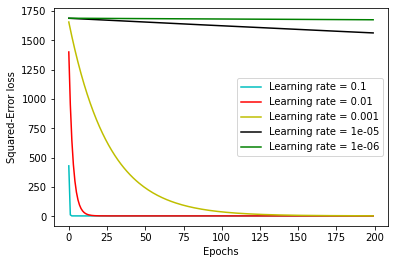

In [126]:
def plot_3c():
    batch_size = 1
    lrs = [10 ** -1, 10 ** -2, 10 ** -3, 10 ** -5, 10 ** -6]
    losses = []
    for lr in lrs:
        neuralnet, loss = train_3_se(batch_size, lr * (10 ** -4))
        losses.append(loss)
    
    # Plot the losses
    colors = ['c', 'r', 'y', 'k', 'g']
    for i in range(len(losses)):
        line, = plt.plot(losses[i], colors[i])
        line.set_label(f'Learning rate = {lrs[i]}')
    
    plt.ylabel('Squared-Error loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

plot_3c()

Best learning rate = 0.001 * (10 ^ (-4)) = 10^(-7)

## Question 3(d)
### Comparision of cross-entropy loss by varying learning rates
The given learning rates are way too large for the model. 
Therefore, modified learning rates which are scaled by a factor of 10^(-4) are used.

(1500, 1, 64) (1500, 1, 10)
(1500, 1, 64) (1500, 1, 10)
(1500, 1, 64) (1500, 1, 10)
(1500, 1, 64) (1500, 1, 10)
(1500, 1, 64) (1500, 1, 10)


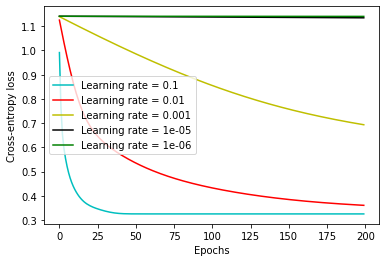

In [127]:
def plot_3d():
    batch_size = 1
    lrs = [10 ** -1, 10 ** -2, 10 ** -3, 10 ** -5, 10 ** -6]
    losses = []
    for lr in lrs:
        neuralnet, loss = train_3_ce(batch_size, lr * (10 ** -4))
        losses.append(loss)
    
    # Plot the losses
    colors = ['c', 'r', 'y', 'k', 'g']
    for i in range(len(losses)):
        line, = plt.plot(losses[i], colors[i])
        line.set_label(f'Learning rate = {lrs[i]}')
    
    plt.ylabel('Cross-entropy loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

plot_3d()

Best learning rate = 0.01 * (10^(-4))= 10^(-6)

## Question 3(e)

### Comparision of squared-error loss by varying mini-batch size

Learning rate = 10^(-5)

(30, 50, 64) (30, 50, 1)
(15, 100, 64) (15, 100, 1)
(6, 250, 64) (6, 250, 1)
(5, 300, 64) (5, 300, 1)
(3, 500, 64) (3, 500, 1)


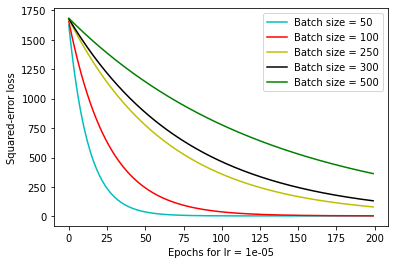

In [137]:
def plot_3e_se():
    lr = 10 ** -5
    batch_sizes = [50, 100, 250, 300, 500]
    losses = []
    for batch_size in batch_sizes:
        neuralnet, loss = train_3_se(batch_size, lr)
        losses.append(loss)
    
    # Plot the losses
    colors = ['c', 'r', 'y', 'k', 'g']
    for i in range(len(losses)):
        line, = plt.plot(losses[i], colors[i])
        line.set_label(f'Batch size = {batch_sizes[i]}')
    
    plt.ylabel('Squared-error loss')
    plt.xlabel(f'Epochs for lr = {lr}')
    plt.legend()
    plt.show()

plot_3e_se()

### Comparision of cross-entropyloss by varying mini-batch size

Learning rate = 10^(-**4**)

(30, 50, 64) (30, 50, 10)
(15, 100, 64) (15, 100, 10)
(6, 250, 64) (6, 250, 10)
(5, 300, 64) (5, 300, 10)
(3, 500, 64) (3, 500, 10)


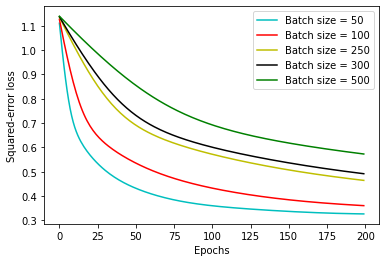

In [138]:
def plot_3e_ce():
    lr = 10 ** -4
    batch_sizes = [50, 100, 250, 300, 500]
    losses = []
    for batch_size in batch_sizes:
        neuralnet, loss = train_3_ce(batch_size, lr)
        losses.append(loss)
    
    # Plot the losses
    colors = ['c', 'r', 'y', 'k', 'g']
    for i in range(len(losses)):
        line, = plt.plot(losses[i], colors[i])
        line.set_label(f'Batch size = {batch_sizes[i]}')
    
    plt.ylabel('Squared-error loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

plot_3e_ce()

### Observation
In both the cases, with the increasing batch-size, performance degrades for the given number of epochs.

### Reason
The number of updates is inversely proportional to the batch-size.
As the batch size increases, fewer corrections are made to the weights.
This leads to the error decreasing slowly.


# Question 4

## Question 4(a)
### Split the data into S1 and S2 datasets

In [139]:
def split_data_4a():
    x, y = preprocess_3()
    seed = 0
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    num_samples = x.shape[0]
    num_samples_s1 = int((num_samples * 0.8 // 50) * 50)
    num_samples_s2 = int((num_samples * 0.2 // 50) * 50)
    s1 = (x[:num_samples_s1], y[:num_samples_s1])
    s2 = (x[:num_samples_s2], y[:num_samples_s2])
    return (s1, s2)
    

## Question 4(b)
### Functions to compute squared-error and cross-entropy loss

In [142]:
# Neural network with Squared-Error loss
def train_4b_se(learning_rate=0.0001): 
    # Number of neurons in each layer
    neurons = [64, 256, 128, 1]
    activations = ['sigmoid', 'sigmoid', 'relu']
    loss_function = 'squared'
    epochs = 200

    # Data preprocessing
    onehotencoded = False
    minibatch = True
    batch_size = 50
    s1, s2 = split_data_4a()

    # Training set is S1
    X, Y = s1
    # Create mini-batches for S1
    num_batches = int(X.shape[0] / batch_size)
    train_X, train_Y = create_minibatches(X, Y, batch_size)
    train_Y = train_Y.reshape((num_batches, batch_size, 1))

    # Test set is S1
    X, Y = s2
    # Create mini-batches for S1
    num_batches = int(X.shape[0] / batch_size)
    test_X, test_Y = create_minibatches(X, Y, batch_size)
    test_Y = test_Y.reshape((num_batches, batch_size, 1))

    print(f'Training set size : {train_X.shape}, {train_Y.shape}')
    print(f'Test set size : {test_X.shape}, {test_Y.shape}')

    # Train the network
    # Pass S2 as the test set with test_epoch = 5
    test_epoch = 5
    neuralnet = Neural_Network(neurons, activations, epochs, learning_rate, loss_function, (test_X, test_Y), test_epoch)
    loss_s1 = neuralnet.train(train_X, train_Y, minibatch=minibatch)   
    loss_s2 = neuralnet.test_errors

    return neuralnet, (loss_s1, loss_s2)

# neuralnet, loss = train_4b_se()

In [140]:
# Neural network with Cross-Entropy loss
def train_4b_ce(learning_rate=0.0001): 
    # Number of neurons in each layer
    neurons = [64, 256, 128, 10]
    activations = ['sigmoid', 'sigmoid', 'softmax']
    loss_function = 'cross-entropy'
    epochs = 200

    # Data preprocessing
    onehotencoded = False
    minibatch = True
    batch_size = 50
    s1, s2 = split_data_4a()
    
    # Training set is S1
    X, Y = s1
    # Create mini-batches for S1
    num_batches = int(X.shape[0] / batch_size)
    train_X, train_Y = create_minibatches(X, Y, batch_size)
    train_Y = train_Y.reshape((num_batches, batch_size, 1))

    # Test set is S1
    X, Y = s2
    # Create mini-batches for S1
    num_batches = int(X.shape[0] / batch_size)
    test_X, test_Y = create_minibatches(X, Y, batch_size)
    test_Y = test_Y.reshape((num_batches, batch_size, 1))

    print(f'Training set size : {train_X.shape}, {train_Y.shape}')
    print(f'Test set size : {test_X.shape}, {test_Y.shape}')

    # Train the network
    # Pass S2 as the test set along with test_epoch = 5
    test_epoch = 5
    neuralnet = Neural_Network(neurons, activations, epochs, learning_rate, loss_function, (test_X, test_Y), test_epoch)
    loss_s1 = neuralnet.train(train_X, train_Y, minibatch=minibatch)        
    loss_s2 = neuralnet.test_errors
    
    return neuralnet, (loss_s1, loss_s2)

# neuralnet, loss = train_4b_ce()

## Question 4(c)
### Selecting a suitable learning rate for squared-error loss 

In [ ]:
def plot_4c():
    lrs = [10**-1, 10**-2, 10**-3, 10**-4, 10**-5, 10**-6]
    losses_s1, losses_s2 = [], []
    
    for lr in lrs:
        neuralnets, losses = train_4b_se(lr)
        # Record every 5th epoch loss
        losses_s1.append(losses[0][::5])
        losses_s2.append(losses[1])
    
    # Plot the losses for the two samples
    colors = ['c', 'r', 'y', 'k', 'g', 'y']
    for i in range(len(losses_s1)):
        line, = plt.plot(losses_s1[i], colors[i])
        line.set_label(f'Learning rate = {lrs[i]}')
    plt.ylabel('Squared-error loss for S1')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    for i in range(len(losses_s2)):
        line, = plt.plot(losses_s2[i], colors[i])
        line.set_label(f'Learning rate = {lrs[i]}')
    plt.ylabel('Squared-error loss for S2')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
plot_4c()

Training set size : (28, 50, 64), (28, 50, 1)
Test set size : (7, 50, 64), (7, 50, 1)
Training set size : (28, 50, 64), (28, 50, 1)
Test set size : (7, 50, 64), (7, 50, 1)


## Question 4(d)
### Selecting a suitable learning rate for cross-entropy loss 

Training set size : (28, 50, 64), (28, 50, 1)
Test set size : (7, 50, 64), (7, 50, 1)
Epoch: 0 Loss: 11.970398779456483
Epoch: 1 Loss: 9.922246037970721
Epoch: 2 Loss: 9.922246037970721
Epoch: 3 Loss: 9.922246037970721
Epoch: 4 Loss: 9.922246037970721
Epoch: 5 Loss: 9.922246037970721
Epoch: 6 Loss: 9.922246037970721
Epoch: 7 Loss: 9.922246037970721
Epoch: 8 Loss: 9.922246037970721
Epoch: 9 Loss: 9.922246037970721
Epoch: 10 Loss: 9.922246037970721
Epoch: 11 Loss: 9.922246037970721
Epoch: 12 Loss: 9.922246037970721
Epoch: 13 Loss: 9.922246037970721
Epoch: 14 Loss: 9.922246037970721
Epoch: 15 Loss: 9.922246037970721
Epoch: 16 Loss: 9.922246037970721
Epoch: 17 Loss: 9.922246037970721
Epoch: 18 Loss: 9.922246037970721
Epoch: 19 Loss: 9.922246037970721
Epoch: 20 Loss: 9.922246037970721
Epoch: 21 Loss: 9.922246037970721
Epoch: 22 Loss: 9.922246037970721
Epoch: 23 Loss: 9.922246037970721
Epoch: 24 Loss: 9.922246037970721
Epoch: 25 Loss: 9.922246037970721
Epoch: 26 Loss: 9.922246037970721
Epoch

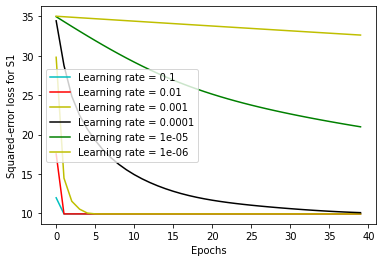

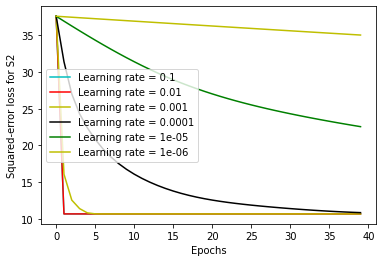

In [86]:
def plot_4c():
    lrs = [10**-1, 10**-2, 10**-3, 10**-4, 10**-5, 10**-6]
    losses_s1, losses_s2 = [], []
    
    for lr in lrs:
        neuralnets, losses = train_4b_ce(lr)
        # Record every 5th epoch loss
        losses_s1.append(losses[0][::5])
        losses_s2.append(losses[1])
    
    # Plot the losses for the two samples
    colors = ['c', 'r', 'y', 'k', 'g', 'y']
    for i in range(len(losses_s1)):
        line, = plt.plot(losses_s1[i], colors[i])
        line.set_label(f'Learning rate = {lrs[i]}')
    plt.ylabel('Squared-error loss for S1')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    for i in range(len(losses_s2)):
        line, = plt.plot(losses_s2[i], colors[i])
        line.set_label(f'Learning rate = {lrs[i]}')
    plt.ylabel('Squared-error loss for S2')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
plot_4c()

For the learning rate of 10^(-5), the error on both S1 (training set) and S2 (test set) declined 

## Question 4(e)
### Comparision between learning rates for 3(c), 3(d) with 4(c), 4(d)